In [41]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import datetime
import time
import matplotlib.pyplot as plt
from etf_tools import (
    EstimatorBucket,
    prepare_etf, ez_plot,
    evaluate_stacking
)
from etf_tools.experimental import prepare_named_etf
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import shuffle as sk_shuffle

from sklearn.metrics import roc_auc_score, accuracy_score
import pickle

plt.style.use('ggplot')
plt.ioff()


In [114]:
src_dir = '../data/raw/groupbycode/trainingset/'
code = '0050'
sample_file = os.path.join(src_dir, f'{code}.csv')
etf = pd.read_csv(sample_file)
display(etf.shape)
display(etf.head(2))
display(etf.tail(2))
display(etf.dtypes)


(1317, 39)

,code,date,name,open,high,low,close,volume,weekday,ema12,...,atr_std_20,vr,obv,obv_ma12,obv_ma12_diff,y_1,y_2,y_3,y_4,y_5
0,50,20130102,元大台灣50,54.0,54.65,53.90,54.40,16487,3,54.400000,...,-107.05500,3.0,16487,16487.0,0.0,54.85,54.50,54.25,53.9,54.1
1,50,20130103,元大台灣50,54.9,55.05,54.65,54.85,29020,4,54.469231,...,-107.07975,3.0,45507,30997.0,14510.0,54.50,54.25,53.90,54.1,54.5


,code,date,name,open,high,low,close,volume,weekday,ema12,...,atr_std_20,vr,obv,obv_ma12,obv_ma12_diff,y_1,y_2,y_3,y_4,y_5
1315,50,20180517,元大台灣50,81.95,82.0,81.20,81.20,1940,4,80.968925,...,-1.122942,1.614290,1555912,1.527453e+06,28459.333333,80.95,NaN,NaN,NaN,NaN
1316,50,20180518,元大台灣50,81.20,81.5,80.85,80.95,2360,5,80.966013,...,-0.903089,1.710301,1553552,1.531188e+06,22364.333333,NaN,NaN,NaN,NaN,NaN


code               int64
date               int64
name              object
open             float64
high             float64
low              float64
close            float64
volume             int64
weekday            int64
ema12            float64
ema26            float64
rsv              float64
k                float64
d                float64
upward           float64
downward         float64
rs               float64
rsi              float64
kbody            float64
kbody_top        float64
kbody_bottom     float64
up_shadow        float64
low_shadow       float64
open_gap         float64
dif              float64
macd             float64
osc              float64
price_std_20     float64
atr_20           float64
atr_std_20       float64
vr               float64
obv                int64
obv_ma12         float64
obv_ma12_diff    float64
y_1              float64
y_2              float64
y_3              float64
y_4              float64
y_5              float64
dtype: object

In [120]:
etf.date.unique()[-100:]

array([20171215, 20171218, 20171219, 20171220, 20171221, 20171222,
       20171225, 20171226, 20171227, 20171228, 20171229, 20180102,
       20180103, 20180104, 20180105, 20180108, 20180109, 20180110,
       20180111, 20180112, 20180115, 20180116, 20180117, 20180118,
       20180119, 20180122, 20180123, 20180124, 20180125, 20180126,
       20180129, 20180130, 20180131, 20180201, 20180202, 20180205,
       20180206, 20180207, 20180208, 20180209, 20180212, 20180221,
       20180222, 20180223, 20180226, 20180227, 20180301, 20180302,
       20180305, 20180306, 20180307, 20180308, 20180309, 20180312,
       20180313, 20180314, 20180315, 20180316, 20180319, 20180320,
       20180321, 20180322, 20180323, 20180326, 20180327, 20180328,
       20180329, 20180330, 20180331, 20180402, 20180403, 20180409,
       20180410, 20180411, 20180412, 20180413, 20180416, 20180417,
       20180418, 20180419, 20180420, 20180423, 20180424, 20180425,
       20180426, 20180427, 20180430, 20180502, 20180503, 20180

In [20]:
trend_up = 1 * (etf.close.rolling(5, 0).max() - etf.close.rolling(20, 0).max().shift(5) > 0)
trend_down = 1 * (etf.close.rolling(5, 0).min() - etf.close.rolling(20, 0).min().shift(5) < 0)

In [21]:
trend_up.name = 'trend_up'
trend_down.name = 'trend_down'
norm_close = etf.close / etf.close.max()

In [27]:
df = pd.concat([norm_close, trend_up, trend_down], axis=1)
df = df.set_index(etf.date.apply(lambda e: str(e)))


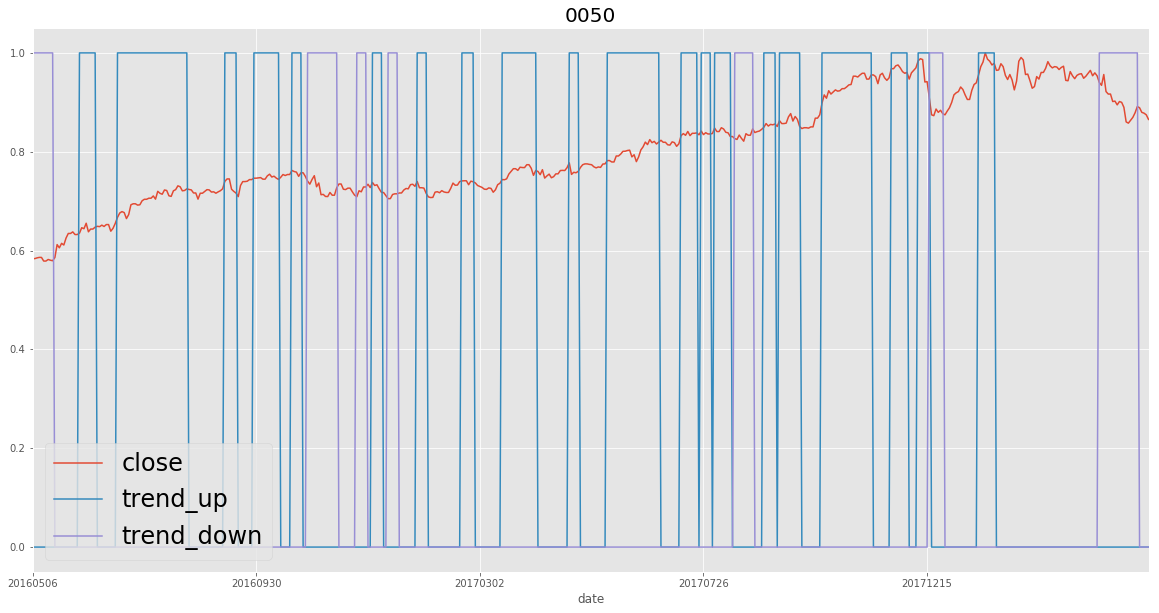

In [29]:
fig = ez_plot(df.tail(500),
              title_prop={'label': '0050', 'size': 20},
              legend_prop={'loc': 'lower left', 'fontsize': 24})
display(fig)

In [30]:
fig.savefig('temp.jpg')

In [65]:
src_dir = '../data/raw/groupbycode/trainingset/'
code = '0050'
sample_file = os.path.join(src_dir, f'{code}.csv')

cont_feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'ema12', 'ema26', 'rsv', 'k', 'd', 'upward',
    'downward', 'rsi', 'open_gap', 'macd', 'osc', 'kbody',
    'price_std_20', 'atr_20', 'atr_std_20',
    'vr', 'obv', 'obv_ma12', 'obv_ma12_diff',
]

cate_feature_cols = [f'month_{i + 1}' for i in range(12)] + [f'week_{i + 1}' for i in range(5)]

label_cols = [f'y_{i}' for i in range(1, 6)]


def feature_prep(df):
    months = pd.get_dummies(pd.Series(df.date.apply(lambda e: (e // 100) % 100)), prefix='month')
    weeks = pd.get_dummies(pd.Series(df.date.apply(lambda e: 1 + (e % 100) // 7)), prefix='week')
    return pd.concat([months, weeks, df[cont_feature_cols]], axis=1)


def rnn_feature_trans(df):
    conts = df[cont_feature_cols]
    norms = ((conts - conts.mean()) / conts.std()).fillna(0)
    return pd.concat([df[cate_feature_cols], norms], axis=1)

def named_by_date(df_gen):
    for df in df_gen:
        yield f'{df.date.values[-1]}'

In [56]:
trainingset = pickle.load(open('lstm/5day_classifier/pairs/0050/201804.p', 'rb'))

In [89]:
X_all, y_all, name_all = prepare_named_etf(sample_file, cont_feature_cols + cate_feature_cols, label_cols, window=5,
                                           etf_prep=lambda df: df.dropna(subset=label_cols),
                                           feature_prep=feature_prep,
                                           # label_prep=lambda df: 1 * (df[label_cols].diff().fillna(0) > 0),
                                           name_prep=named_by_date,
                                           feature_trans=rnn_feature_trans)

In [97]:
index = 1301
print(y_all[index, :], name_all[index])

[[78.95 79.5  80.   80.45 80.65]] 20180503


In [113]:
os.path.dirname(sample_file)

'../data/raw/groupbycode/trainingset'

In [101]:
data = pd.DataFrame(dict(x=X_all, y=y_all), )

ValueError: If using all scalar values, you must pass an index

In [57]:
(X_val, y_val) = (trainingset['validation']['x'], trainingset['validation']['y'])

In [62]:
y_val.flatten()

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1])